<a href="https://colab.research.google.com/github/shkailas/CementAnalysis/blob/main/NewApproachGann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from tqdm import tqdm
import time
import matplotlib
# Set random seed for reproducibility
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0


In [ ]:
!nvidia-smi

Thu Nov 19 22:09:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
base_path = "/content/drive/My Drive/GAN" 
dataroot = os.path.join(base_path, 'Data/3Phase')
out_path = os.path.join(base_path, 'Output')
model_path = os.path.join(base_path, 'Model')

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this size using a transformer.
crop_size = 200
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_iters = 25000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

samples_count = 0

im_save = True
load = False
save = True

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [ ]:
tr1 = transforms.Compose([transforms.RandomCrop((crop_size * 2, crop_size * 2)),
                    transforms.RandomRotation(180),
                    transforms.CenterCrop((crop_size, crop_size))])
# tr2 = transforms.RandomResizedCrop(crop_size, scale=(0.9, 1.1), ratio=(1,1), interpolation=2)
tr2 = transforms.RandomCrop(crop_size)
image_gen = transforms.RandomChoice([tr1, tr2])

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                          image_gen,
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomVerticalFlip(),
                          transforms.Resize(image_size),
                          transforms.Grayscale(1),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5), (0.5))
                          ]))

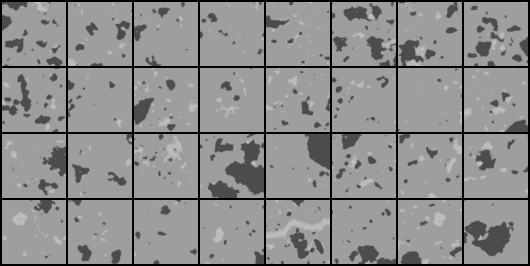

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True, pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
img = (real_batch[0].to(device)[:64] + 1 )/ 2
img = vutils.make_grid(img, padding=2)
img = transforms.ToPILImage()(img.cpu())
display(img)

In [ ]:
# np.unique(((real_batch[0] + 1) / 2).numpy(), return_counts=True)
# (array([0.29803923, 0.61960787, 0.7372549 , 0.81960785], dtype=float32), array([  434,  1475, 24307, 13784]))

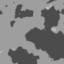

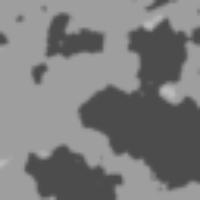

In [ ]:
index = 19

img = transforms.ToPILImage()((real_batch[0][index] + 1) / 2)
display(img)

reszied_img = transforms.Resize(crop_size, interpolation=2)(img)
display(reszied_img)

# th_img = transforms.ToTensor()(reszied_img)
# # th_img = threshold(th_img)
# th_img = transforms.ToPILImage()(th_img)
# display(th_img)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # input is Z, going into a convolution

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

print(summary(netG, (nz, 1, 1)))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
-------

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0.0).cuda()

    def forward(self, x):
        if self.training:
            sampled_noise = self.noise.repeat(*x.size()).normal_(mean=0, std=self.sigma)
            x = x + sampled_noise
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            GaussianNoise(),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            GaussianNoise(),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            GaussianNoise(),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Conv2d(ndf * 8, 1, 3, 1, 1, bias=False),
            nn.AdaptiveAvgPool2d(1)
        )


    def forward(self, x):
      return self.main(x)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
summary(netD, (nc, image_size, image_size))

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GaussianNoise()
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GaussianNoise()
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): GaussianNoise()
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 

In [ ]:
if load:
  netD.load_state_dict(torch.load(os.path.join(model_path, 'disc.pkl')))
  netG.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
  print("Loaded.")

In [ ]:
# Initialize BCELoss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def save_to_drive(iter=0):
  img = img_list[-1]
  img = transforms.ToPILImage()(img)
  img.save(os.path.join(out_path, 'combined_unscaled_' + str(iter) + '.png'))

  if crop_size != image_size:
    with torch.no_grad():
        fake = (netG(fixed_noise).detach().cpu() + 1) / 2

    scaled = []
    for i in range(fake.shape[0]):
      img = transforms.ToPILImage()(fake[i])
      img = transforms.Resize(crop_size, interpolation=1)(img)
      # img.save(os.path.join(out_path,  str(i) + '.png'))
      img = transforms.ToTensor()(img)
      # img = threshold(img)
      scaled.append(img)

    scaled = torch.stack(scaled)
    img = vutils.make_grid(scaled, padding=2)
    img = transforms.ToPILImage()(img)
    img.save(os.path.join(out_path, 'combined_scaled_' + str(iter) + '.png'))

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [ ]:
def roundrobin_infinite(*loaders):
    if not loaders:
        return
    iters = [iter(loader) for loader in loaders]
    while True:
        for i in range(len(iters)):
            it = iters[i]
            try:
                yield next(it)
            except StopIteration:
                iters[i] = iter(loaders[i])
                yield next(iters[i])

In [ ]:
# Training Loop
start_iter = 0
print("Starting Training Loop...")
start_time = time.time()
loader = roundrobin_infinite(dataloader)
for i in range(start_iter, start_iter+num_iters+1):
    data = next(loader)
    # print("--- %s seconds ---" % (time.time() - start_time))
    
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
        
    total_error = errG
    total_error.backward()
    
    D_G_z2 = output.mean().item()
    optimizerG.step()

    # Output training stats
    if i % 10 == 0:
        duration = (time.time() - start_time)/10
        eta = duration * (start_iter+num_iters+1 - i) / 60
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f, Per_iter: %.3fs, ETA: %.2fm'
              % (i, num_iters, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, duration, eta))
        start_time = time.time()
        # print(duration)

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (i % 100 == 0) or (i == num_iters-1):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    if (i % 500 == 0) and im_save:
      netG.eval()
      save_to_drive(i)
      netG.train()

Starting Training Loop...
[0/25000]	Loss_D: 0.0806	Loss_G: 0.9537	D(x): 0.9115	D(G(z)): 0.1395 / 0.0329, Per_iter: 0.034s, ETA: 14.31m
[10/25000]	Loss_D: 0.4746	Loss_G: 1.0752	D(x): 1.1799	D(G(z)): 0.6147 / -0.0236, Per_iter: 0.535s, ETA: 222.95m
[20/25000]	Loss_D: 0.1482	Loss_G: 0.9709	D(x): 1.0591	D(G(z)): 0.3007 / 0.0308, Per_iter: 0.449s, ETA: 187.10m


KeyboardInterrupt: ignored

In [ ]:
if save:
  torch.save(netD.state_dict(), os.path.join(model_path, 'disc.pkl'))
  torch.save(netG.state_dict(), os.path.join(model_path, 'gen.pkl'))
  print("Model saved.")
else:
  print("Model not saved.")

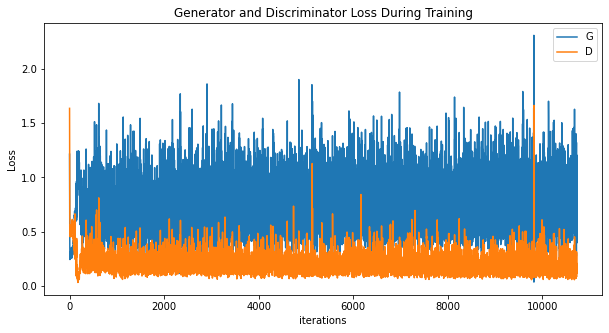

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
matplotlib.rcParams['animation.embed_limit'] = 2**128

HTML(ani.to_jshtml())

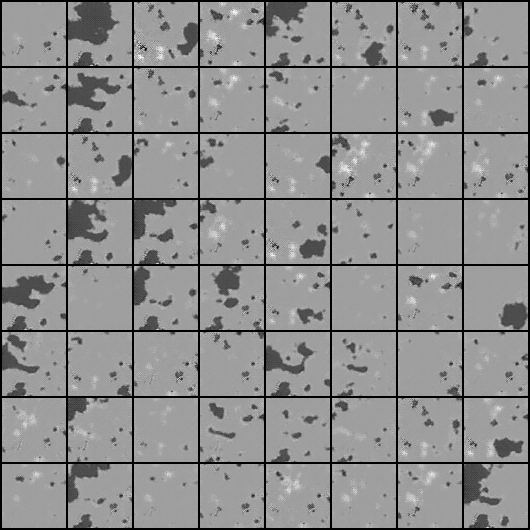

In [ ]:
img = img_list[-1]
img = transforms.ToPILImage()(img)
if im_save:
  img.save(os.path.join(out_path, 'combined_unscaled.png'))
display(img)

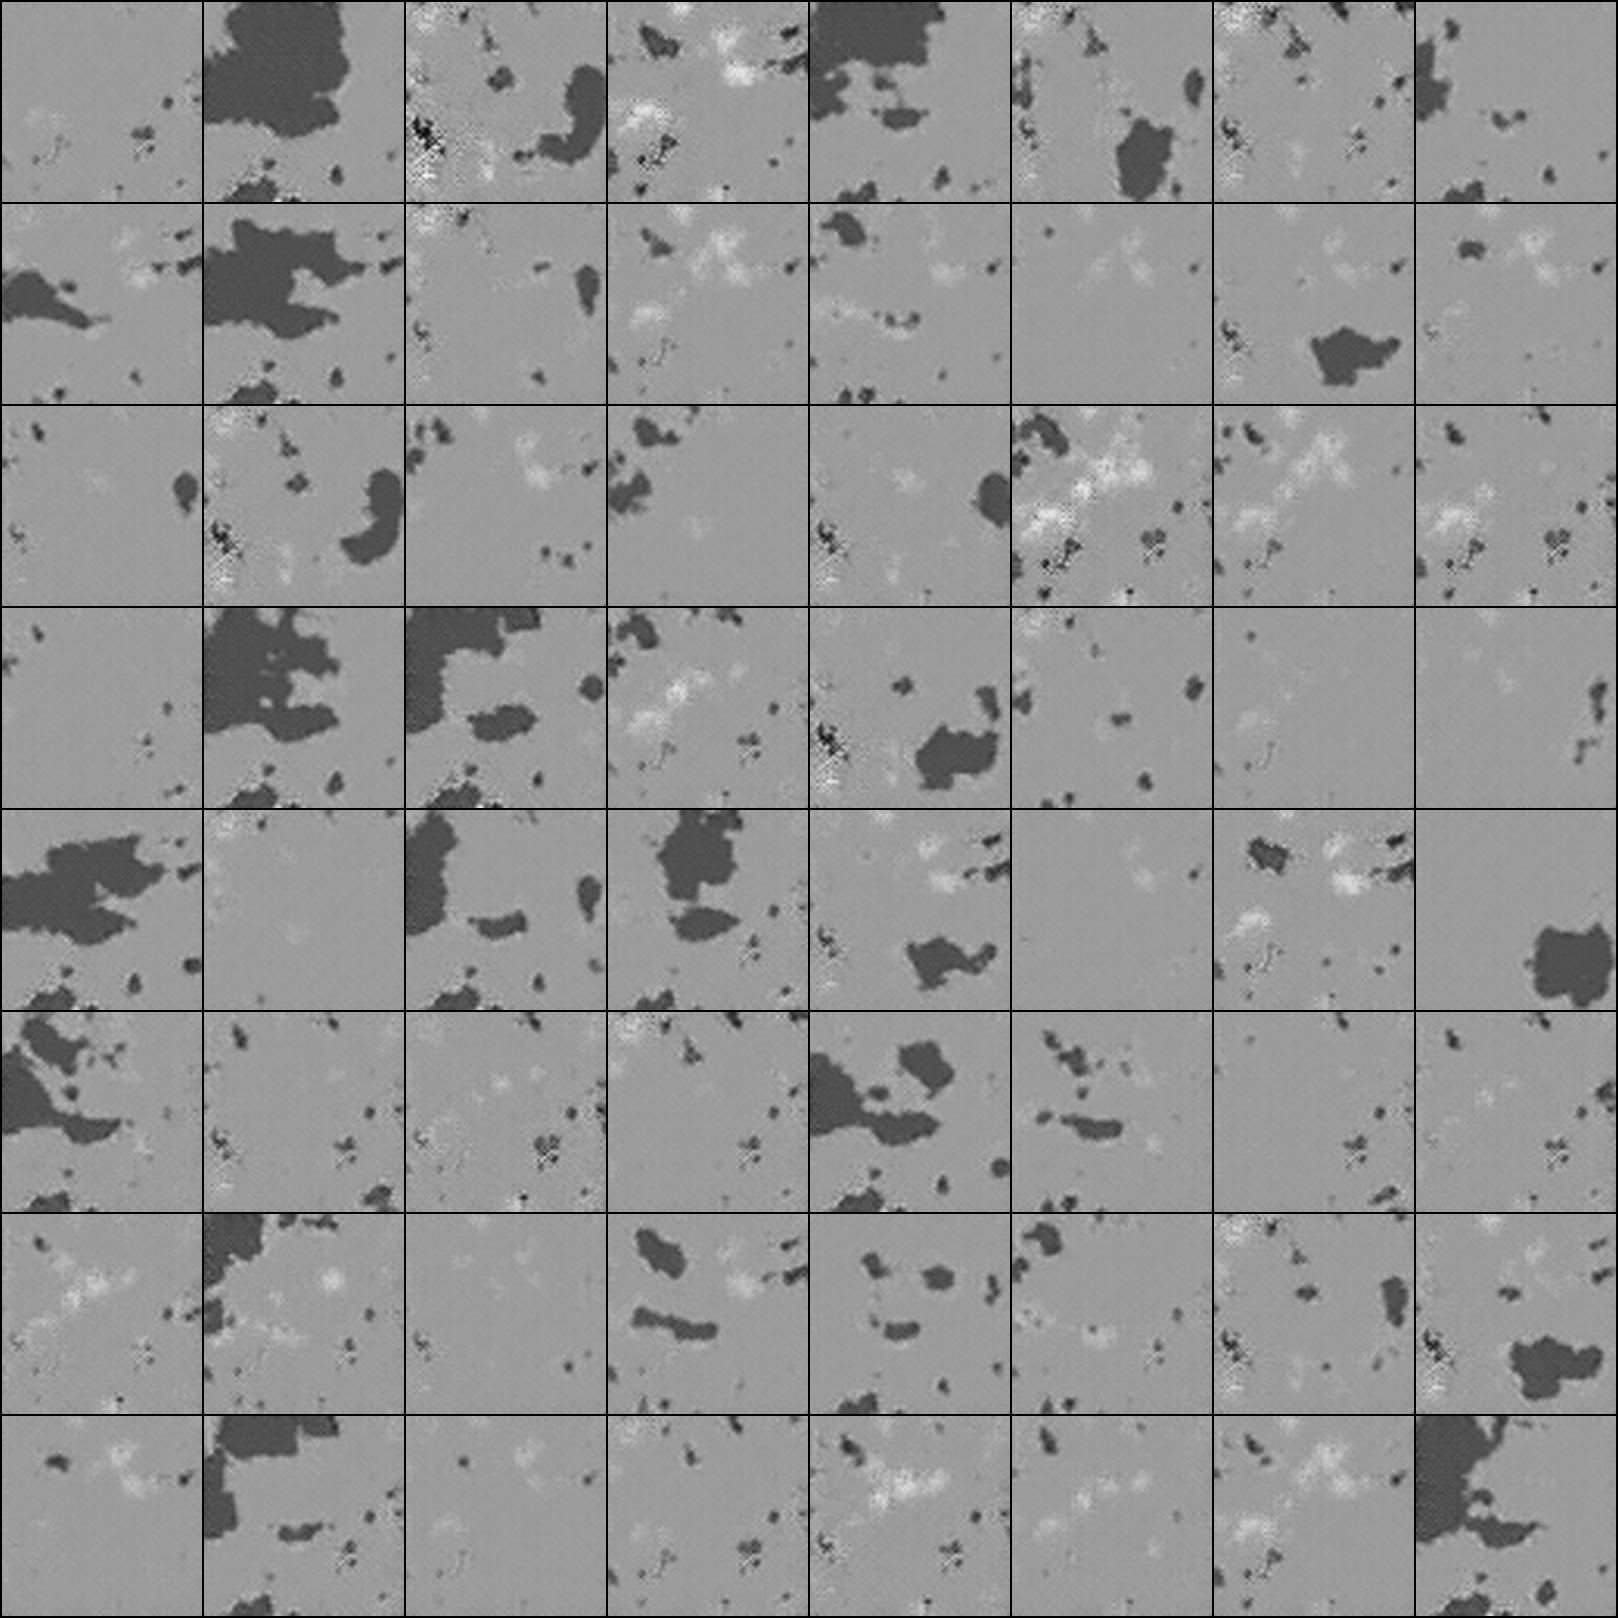

In [ ]:
if crop_size != image_size:
  with torch.no_grad():
      fake = (netG(fixed_noise).detach().cpu() + 1) / 2

  scaled = []
  for i in range(fake.shape[0]):
    img = fake[i]
    img = transforms.ToPILImage()(img)
    img = transforms.Resize(crop_size, interpolation=1)(img)
    # img.save(os.path.join(out_path,  str(i) + '.png'))
    img = transforms.ToTensor()(img)
    scaled.append(img)

  scaled = torch.stack(scaled)
  img = vutils.make_grid(scaled, padding=2)
  img = transforms.ToPILImage()(img)
  if im_save:
    img.save(os.path.join(out_path, 'combined_scaled.png'))
  display(img)

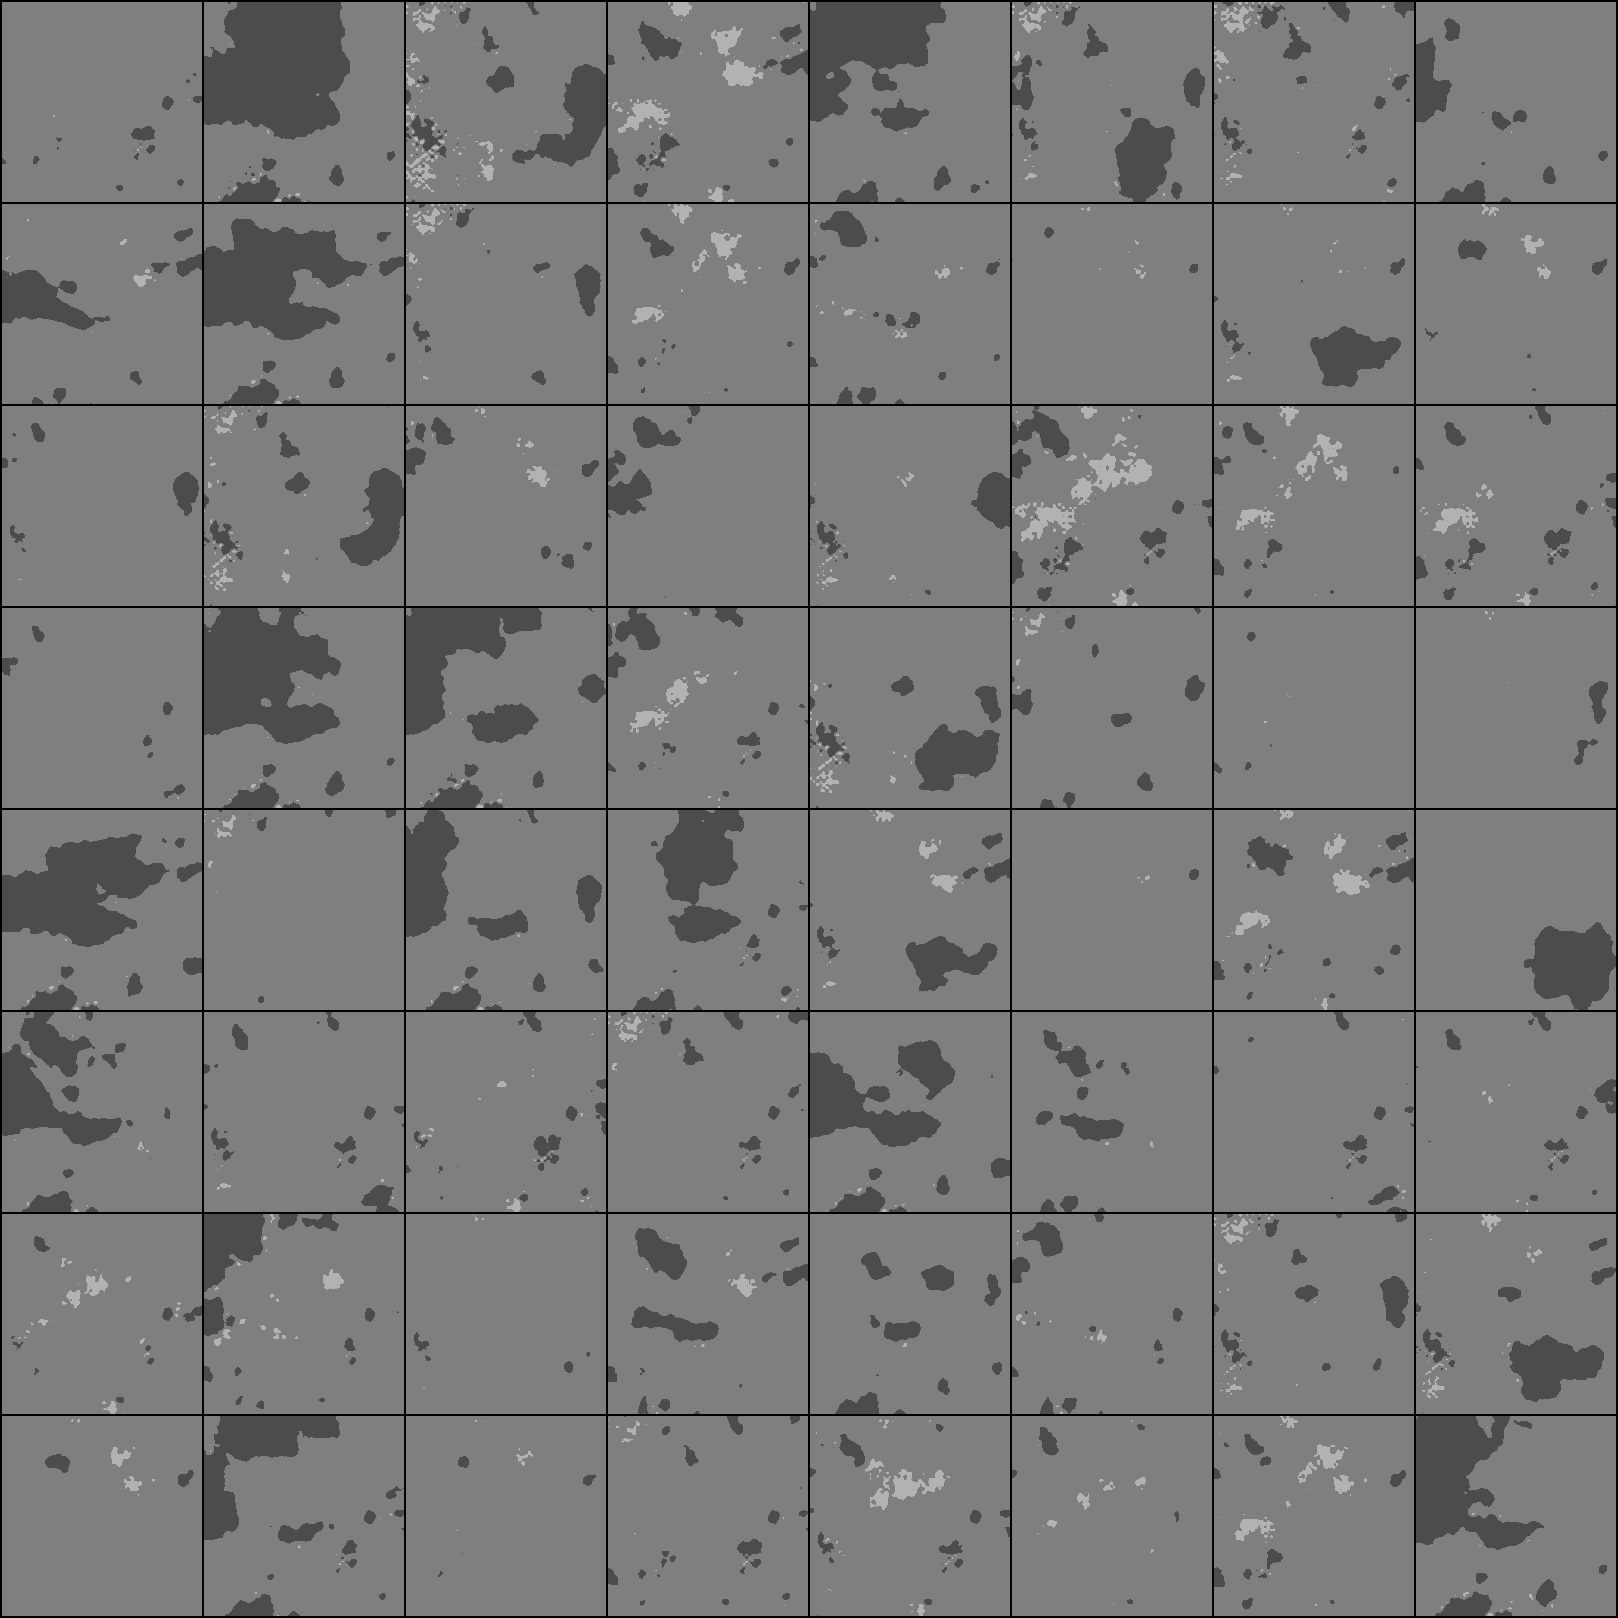

In [ ]:
def threshold(img):
	img[img<0.5] = 0.3
	img[(img>0.5) & (img < 0.7)] = 0.5
	img[img > 0.7] = 0.7
	return img


if crop_size != image_size:
	with torch.no_grad():
			fake = (netG(fixed_noise).detach().cpu() + 1) / 2

	scaled = []
	for i in range(fake.shape[0]):
		img = fake[i]
		img = transforms.ToPILImage()(img)
		img = transforms.Resize(crop_size, interpolation=1)(img)
		img = transforms.ToTensor()(img)
		img = threshold(img)
		scaled.append(img)

	scaled = torch.stack(scaled)
	img = vutils.make_grid(scaled, padding=2)
	img = transforms.ToPILImage()(img)
	if im_save:
		img.save(os.path.join(out_path, 'combined_scaled_sharpened.png'))
	display(img) # displaying images 

In [ ]:
if samples_count > 0 :
  with torch.no_grad():
    samples_noise = torch.randn(samples_count, nz, 1, 1, device=device)
    samples_gen = (netG(samples_noise).detach().cpu() + 1) / 2

  samples = []
  for i in tqdm(range(samples_gen.shape[0])):
    img = samples_gen[i]
    img = transforms.ToPILImage()(img)
    img = transforms.Resize(crop_size, interpolation=1)(img)
    img = transforms.ToTensor()(img)
    img = threshold(img)
    img = transforms.ToPILImage()(img)
    img.save(os.path.join(out_path, 'samples',  'sample_' + str(i) + '.png')) # Saving the images